In [13]:
import numpy as np
import fabio
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import psutil
from scipy.optimize import minimize
import scipy.constants as sc

def simple_kmeans(data, n_clusters, max_iters=20):
    """One-dimensional K-Means clustering"""
    centers = np.random.choice(data, size=n_clusters, replace=False)
    for _ in range(max_iters):
        distances = np.abs(data[:, None] - centers)
        labels = np.argmin(distances, axis=1)
        new_centers = np.array([
            data[labels == i].mean() if np.any(labels == i) else centers[i]
            for i in range(n_clusters)
        ])
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    return labels, centers


def evaluate_center(distances, n_clusters, threshold):
    labels, centers_k = simple_kmeans(distances, n_clusters)
    inlier_count = np.sum(np.abs(distances - centers_k[labels]) < threshold)
    return inlier_count, centers_k


def ransac_center_optimized(points,
                            num_iterations=500,
                            threshold=5,
                            n_clusters=5):
    # Calculate all candidate centers (as described above)
    indices = np.random.choice(len(points), (num_iterations, 3), replace=False)
    pts = points[indices]
    pt1, pt2, pt3 = pts[:, 0, :], pts[:, 1, :], pts[:, 2, :]
    mid1 = (pt1 + pt2) / 2
    dir1 = np.stack((pt2[:, 1] - pt1[:, 1], pt1[:, 0] - pt2[:, 0]), axis=1)
    mid2 = (pt2 + pt3) / 2
    dir2 = np.stack((pt3[:, 1] - pt2[:, 1], pt2[:, 0] - pt3[:, 0]), axis=1)
    A = np.empty((num_iterations, 2, 2))
    A[:, :, 0] = dir1
    A[:, :, 1] = -dir2
    b = mid2 - mid1
    det = A[:, 0, 0] * A[:, 1, 1] - A[:, 0, 1] * A[:, 1, 0]
    valid = np.abs(det) > 1e-8
    t = np.full(num_iterations, np.nan)
    t[valid] = (A[valid, 1, 1] * b[valid, 0] -
                A[valid, 0, 1] * b[valid, 1]) / det[valid]
    centers = mid1 + t[:, None] * dir1
    valid_centers = centers[valid]

    # Calculate the distance matrix
    distances = np.linalg.norm(points[:, None, :] - valid_centers[None, :, :],
                               axis=2)

    # Execute K-means and inlier statistics in parallel
    cpu_num = psutil.cpu_count(logical=False)
    results = Parallel(n_jobs=cpu_num, verbose=1)(
        delayed(evaluate_center)(distances[:, i], n_clusters, threshold)
        for i in range(distances.shape[1]))

    # Find the best result
    inlier_counts, centers_k_list = zip(*results)
    best_idx = np.argmax(inlier_counts)
    bcx0, bcy0 = valid_centers[best_idx]
    best_centers_k = centers_k_list[best_idx]
    return bcx0, bcy0, np.sort(best_centers_k)


def adaptive_threshold(arr):
    max_val = np.max(arr)
    max_count = np.count_nonzero(arr == max_val)

    if max_count > 50:  # mask gap
        arr[arr == max_val] = 0

    num_points = arr.shape[0] + arr.shape[1]
    top_indices = np.argsort(arr.flatten())[-num_points:]
    mask = np.zeros_like(arr, dtype=bool)
    row_indices, col_indices = np.unravel_index(top_indices, arr.shape)
    mask[row_indices, col_indices] = True
    mask2 = arr > 0
    result_array = arr * mask * mask2
    return result_array

In [14]:
calibrant = {
    "LaB6":
    "4.15682600;2.93931985;2.39994461;2.07841300;" +
    "1.85898910;1.69701711;1.46965993;1.38560867;" +
    "1.31450380;1.25333020;1.19997231;1.15289610",
    "Si":
    "3.13570166;1.92021727;1.63756679;1.35779865;" +
    "1.24600149;1.10863796;1.04523389;0.96010863;" +
    "0.91803944;0.85874727;0.82824941;0.78392542",
    "AgBh":
    "5.83800000e+01;2.91900000e+01;1.94600000e+01;" +
    "1.45950000e+01;1.16760000e+01;9.73000000e+00;" +
    "8.34000000e+00;7.29750000e+00;6.48666667e+00;" +
    "5.83800000e+00;5.30727273e+00;4.86500000e+00",
    "CeO2":
    "3.12441816;2.70582550;1.91330756;1.63167417;" +
    "1.56220908;1.35291275;1.24151789;1.21008195;" +
    "1.10464863;1.04147272;0.95665378;0.91473597",
    "α-Al2O3":
    "3.47871214;2.55009722;2.37850000;2.16461667;" +
    "2.08460357;1.96343287;1.73935607;1.60090113;" +
    "1.54602246;1.51417384;1.51041347;1.40399710"
}


class Fit_Func:

    def __init__(self, pts, two_theta):
        self.pts = pts
        self.two_theta = two_theta

    def residue_tth(self, params):
        # params order: [bcx, bcy, distancep, htilt, vtilt]
        bcx, bcy, distancep, htilt, vtilt = params
        cosh = np.cos(htilt)
        sinh = np.sin(htilt)
        cosv = np.cos(vtilt)
        sinv = np.sin(vtilt)
        r12 = cosv * sinh
        r13 = sinv
        r22 = cosh
        r32 = -sinh * sinv
        r33 = cosv
        sum = 0
        for xy, ring_tth in zip(self.pts, self.two_theta):
            py, px = xy
            oldy, oldz = px - bcx, bcy - py
            xp = r12 * oldy + r13 * oldz
            yp = r22 * oldy
            zp = r32 * oldy + r33 * oldz
            dist_x = distancep - xp
            tth_map = np.arctan2(np.hypot(yp, zp), dist_x)
            sum += np.sum(np.square(tth_map - ring_tth))
        return sum


def calc_twotheta_list(calibrant_d_str, wavelength, max_rings):
    d_spacings = np.fromstring(calibrant_d_str, dtype=np.float64, sep=';')
    max_rings = min(d_spacings.shape[0], max_rings)
    d_spacings = d_spacings[0:max_rings]
    return np.arcsin(wavelength / 2 / d_spacings) * 2


def adaptive_tthrange_list(tth_list_all, err, max_rings):
    '''
    tth_list_all: tth_list of maxrings (12) 
    err: twotheta error in radians
    return an adaptive tuple of (tthmin, tthmax) with error of min(err, 0.4*diff)
    '''
    diff = np.diff(tth_list_all) * 0.4
    min_diff = np.insert(diff, 0, diff[0])
    max_diff = np.append(diff, diff[-1])
    tth_min = tth_list_all - np.minimum(min_diff, err)
    tth_max = tth_list_all + np.minimum(max_diff, err)
    return (tth_min[0:max_rings], tth_max[0:max_rings])


def tilt_matrix(horizonTilt, verticalTilt):
    cosphi = np.cos(horizonTilt)
    sinphi = np.sin(horizonTilt)
    cospsi = np.cos(verticalTilt)
    sinpsi = np.sin(verticalTilt)
    Rz2_rot = np.matrix([[cosphi, -sinphi, 0], [sinphi, cosphi, 0], [0, 0, 1]])
    Ry2_rot = np.matrix([[cospsi, 0, -sinpsi], [0, 1, 0], [sinpsi, 0, cospsi]])
    d_rot = Rz2_rot.dot(Ry2_rot)
    return d_rot


def get_tthmap(bcx, bcy, distance, pixelsize, imarray, horizonTilt,
               verticalTilt):
    '''
    bcx, bcy: beam center in pixels
    distance: distance from sample to detector in mm
    pixelsize: in mm
    horizonTilt, verticalTilt: in radians
    '''
    Npixelsy, Npixelsx = imarray.shape
    oldx = np.zeros_like(imarray)
    oldy, oldz = np.meshgrid(
        np.arange(Npixelsx) - bcx, bcy - np.arange(Npixelsy))
    distancep = distance / pixelsize
    xp, yp, zp = rotationByMatrix(
        tilt_matrix(horizonTilt, verticalTilt).I, oldx, oldy, oldz)
    dist_x = distancep - xp
    return np.arccos(
        dist_x / np.sqrt(np.square(dist_x) + np.square(yp) + np.square(zp)))


def rotationByMatrix(mat, x, y, z):
    rotated = np.matmul(np.stack((x, y, z), axis=-1), np.array(mat).T)
    return (rotated[..., 0], rotated[..., 1], rotated[..., 2])


def fit_from_beamcenter_and_radius(img,
                                   bcx0,
                                   bcy0,
                                   radius,
                                   calibrant_d_str,
                                   wavelength,
                                   max_rings=4,
                                   pixelsize=0.0732422):
    twotheta_list = calc_twotheta_list(calibrant_d_str, wavelength, max_rings)
    tan_tth = np.tan(twotheta_list)
    distp0 = radius / tan_tth[0]
    # tth range: at least 20 pixels
    err_min0 = np.arctan2(20 + radius, distp0) - twotheta_list[0]
    err_min1 = 0.33 * (twotheta_list[-1] - twotheta_list[-2])
    err_min = min(err_min0, err_min1)
    # initial tth range for fitting
    err_initial = 0.25 * (twotheta_list[1] - twotheta_list[0])
    tth_list_all = calc_twotheta_list(calibrant_d_str, wavelength, 12)
    tth_min0, tth_max0 = adaptive_tthrange_list(tth_list_all, err_initial, 2)

    tth_map = get_tthmap(bcx0, bcy0, distp0 * pixelsize, pixelsize, img, 0, 0)
    pts = [
        np.where((tth_map <= tmax) & (tth_map >= tmin)
                 & (img > 0)) for tmin, tmax in zip(tth_min0, tth_max0)
    ]

    ht0 = 0.00001
    vt0 = 0.00001
    # fit first two diffraction rings
    f1 = Fit_Func(pts[0:2], twotheta_list[0:2])
    init_params = np.array([bcx0, bcy0, distp0, ht0, vt0])
    fitted = minimize(f1.residue_tth, init_params, method='Nelder-Mead')
    # then fit all the diffraction rings
    tth_map = get_tthmap(fitted.x[0], fitted.x[1], fitted.x[2] * pixelsize,
                         pixelsize, img, fitted.x[3], fitted.x[4])
    tth_min1 = twotheta_list - err_min
    tth_max1 = twotheta_list + err_min
    pts1 = [
        np.where((tth_map <= tmax) & (tth_map >= tmin)
                 & (img > 0)) for tmin, tmax in zip(tth_min1, tth_max1)
    ]

    f2 = Fit_Func(pts1, twotheta_list)
    init_params1 = np.array(
        [fitted.x[0], fitted.x[1], fitted.x[2], fitted.x[3], fitted.x[4]])
    final_fit = minimize(f2.residue_tth, init_params1, method='Nelder-Mead')
    # update params
    bcx = final_fit.x[0]
    bcy = final_fit.x[1]
    dist = final_fit.x[2] * pixelsize
    horizontalTilt = np.rad2deg(final_fit.x[3])
    verticalTilt = np.rad2deg(final_fit.x[4])
    return bcx, bcy, dist, horizontalTilt, verticalTilt


LAB6-12S.tif.gz rb fabio.<gzip _io.BufferedReader name='LAB6-12S.tif.gz' 0x1c49466c460>


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 480 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished


Initial center from RANSAC: 1158.4006487301713 3044.4459700054176
First arc radius: 1370.59810147922


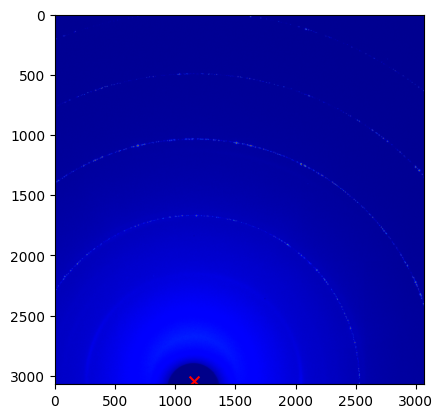

In [15]:
data = 'LAB6-12S.tif.gz'
image = fabio.open(data).data
thresh = adaptive_threshold(image)
y_coords, x_coords = np.where(thresh > 0)
points = np.column_stack((x_coords, y_coords))
wavelength = 1.2398 # in Angstroms
pixelsize = 0.0732422
max_rings = 4

# Get the center and clustering radii
bcx0, bcy0, radii = ransac_center_optimized(points, n_clusters=max_rings)
# Sort the radii in ascending order and take the first one (smallest radius)
if radii.shape[0] > 1:
    two_theta = calc_twotheta_list(calibrant['LaB6'], wavelength, 2)
    tan_2theta = np.tan(two_theta)
    expected_ratio = tan_2theta[1] / tan_2theta[0]
    current_radii = radii.copy()
    while len(current_radii) > 1:
        actual_ratio = current_radii[1] / current_radii[0]
        if np.isclose(actual_ratio, expected_ratio, rtol=0.2):
            break
        current_radii = current_radii[1:]
    radius = current_radii[0]
else:
    radius = radii[0]

print("Initial center from RANSAC:", bcx0, bcy0)
print("First arc radius:", radius)
plt.imshow(image, cmap='jet', clim=(0, 1000))
plt.scatter(bcx0, bcy0, c='red', marker='x', s=50)
plt.show()

In [16]:
bcx, bcy, dist, horizontalTilt, verticalTilt = fit_from_beamcenter_and_radius(thresh,
                                   bcx0,
                                   bcy0,
                                   radius,
                                   calibrant['LaB6'],
                                   wavelength,
                                   max_rings=max_rings,
                                   pixelsize=pixelsize)
print(f"Final center: {bcx}, {bcy}")
print(f"Distance: {dist} mm" )
print(f"Horizontal tilt: {horizontalTilt} deg.", )
print(f"Vertical tilt: {verticalTilt} deg.")

Final center: 1149.851074697483, 3040.7949700344816
Distance: 325.8247796953403 mm
Horizontal tilt: -0.3530121523521848 deg.
Vertical tilt: 0.6575360717077632 deg.


In [17]:
angleRange = np.linspace(0, 360, 361)
two_theta = calc_twotheta_list(calibrant['LaB6'], wavelength, max_rings)
two_theta, angleRange = np.meshgrid(two_theta, np.deg2rad(angleRange))
oldy = np.cos(angleRange)
oldz = np.sin(angleRange)
oldx = np.zeros_like(oldy)
xp, yp, zp = rotationByMatrix(
    tilt_matrix(np.deg2rad(horizontalTilt), np.deg2rad(verticalTilt)).I, oldx,
    oldy, oldz)
square_tan2theta = np.square(np.tan(two_theta))
a1 = -square_tan2theta * np.square(xp) + np.square(yp) + np.square(zp)
distancep = dist / pixelsize
b1 = 2 * distancep * square_tan2theta * xp
c1 = -square_tan2theta * distancep * distancep
n = (-b1 + np.sqrt(b1 * b1 - 4 * a1 * c1)) / 2 / a1
px = bcx + oldy * n
py = bcy - oldz * n

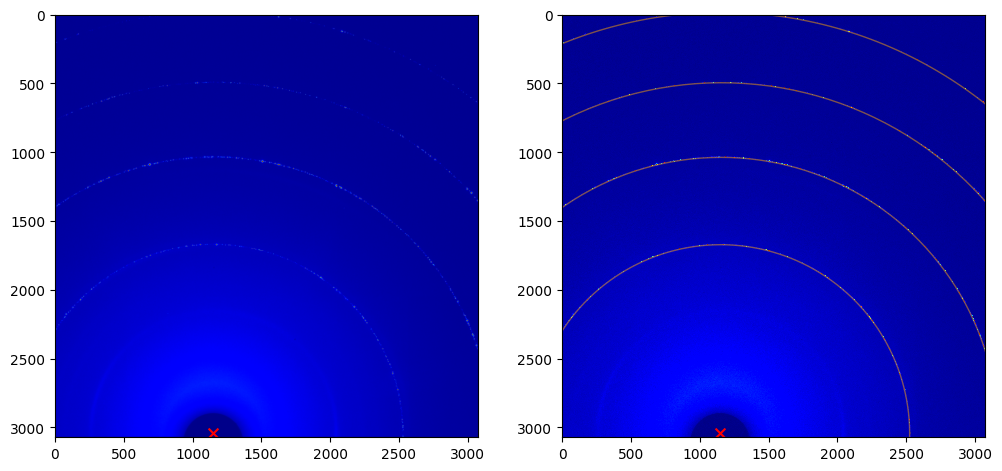

In [18]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
plt.imshow(image, cmap='jet', vmin=0, vmax=1000,aspect='equal')
plt.scatter(bcx, bcy, c='red', marker='x', s=50)
plt.subplot(1,2,2)
plt.imshow(image,
            cmap='jet',
            interpolation="nearest",
            vmin=0,
            vmax=1000,aspect='equal')
plt.plot(px, py, color='orange', alpha=0.5, lw=1)
plt.scatter(bcx, bcy, c='red', marker='x', s=50)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()